# Cad: Usd Exchange Rate Prediction (Based on 2012-2018)

for TRY Conference (2018) 
by Josephine Choi and Lei Jin 


## Background

This Jupyter  Notebook is created based on webposts by Illiya Valchanov / Rohit Garg 

Illiya Valchanov 
https://datascienceplus.com/how-to-apply-monte-carlo-simulation-to-forecast-stock-prices-using-python/ (Dec 2017) 

Rohit Garg 
https://analyticsindiamag.com/a-primer-to-monte-carlo-simulation-in-python/ (Mar 2018)

The original code is for building a monte carlo simulation model for stock pricing 

The following YouTube video are helpful in understanding monte carlo simulation 

Understanding and creating Monte Carlo Simulation Step by Step 
https://www.youtube.com/watch?v=3gcLRU24-w0



In [31]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns
import numpy as np
from scipy.stats import norm

## Step 1: Loading the data into Python

- Daily exchange rate data can be found through Bank of Canada website
- As part of the preprocessing, files were downloaded yearly and need to be combined
- Data might be also available through REST API (e.g. quandl) 



In [95]:
Ex2012 = pd.read_excel("data/Ex2012.xlsx",parse_dates=True,index_col=0)
Ex2013 = pd.read_csv("data/Ex2013.csv",skiprows=8,parse_dates=True,index_col=0)
Ex2014 = pd.read_csv("data/Ex2014.csv",skiprows=8,parse_dates=True,index_col=0)
Ex2015 = pd.read_csv("data/Ex2015.csv",skiprows=8,parse_dates=True,index_col=0)
Ex2016 = pd.read_csv("data/Ex2016.csv",skiprows=8,parse_dates=True,index_col=0)
Ex2017 = pd.read_csv("data/Ex2017.csv",skiprows=8,parse_dates=True,index_col=0)
Ex2018 = pd.read_csv("data/Ex2018.csv",skiprows=8,parse_dates=True,index_col=0)


Ex = Ex2012.append(Ex2013).append(Ex2014).append(Ex2015).append(Ex2016).append(Ex2017).append(Ex2018)
Ex.sample(5)


KeyError: 1


## Step 2: Inspect the data and Cleaning the data for model

- Unlike spreadsheet tools like Excel, data inspection through statistics tools (e.g. R) or programming language (e.g. Python) do not rely on visual inspection
- Here are some of the commands that are useful for inspecting data in python 
  * df.describe()
  * df.sample()
  * df.info()
- Remove erroneous data 
- Missing data can be filled with a) mean b) mode c) backfilling or forward filling 
- Make sure the data types were set up correctly
- Inspect the data again before moving forward to the next stage 


In [34]:
Ex.describe()
Ex.sample(20)
Ex['date']=Ex.index.values


#Don't know whether these were coming from 

Ex=Ex[Ex.date!='ERROR']
Ex=Ex[Ex.date!='date']
Ex=Ex[Ex.IEXE0101 != -64]
Ex=Ex[Ex.IEXE0101 != '-64']

# Opted to fill the bank holiday (empty fields) with forward filling (ffill). Back filling should do the trick as well 
Ex.IEXE0101=Ex['IEXE0101'].fillna(method="ffill")
Ex["IEXE0101"]=Ex["IEXE0101"].fillna(1)

#Set the type to the correct type 
Ex['IEXE0101'] = Ex['IEXE0101'].astype('float')

Ex['date'] = Ex['date'].astype('datetime64[ns]')

#for some strange reason, there were dates >2019, and thus needs to be removed

Ex=Ex[Ex.date<'2019-01-01']
#Ex.date = Ex.date.apply(pd.to_datetime, format='%d/%m/%Y')
Ex.sort_values(by=['date'])
Ex.set_index(Ex.date,inplace=True)


#Ex=Ex.drop('date', axis=1)
#Ex.index=Ex['date']



In [35]:
Ex.info()

print("-"*40)

Ex.describe()
#Ex.drop('date',axis=1)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1606 entries, 2012-01-02 to 2018-03-15
Data columns (total 2 columns):
IEXE0101    1606 non-null float64
date        1606 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 37.6 KB
----------------------------------------


,IEXE0101
count,1606.000000
mean,1.174692
std,0.135729
min,0.971000
25%,1.033200
50%,1.201550
75%,1.303150
max,1.458900


## Step 3: Building the financial model

- Inspect the general trend of existing data 
- We see gradual growth over the past five years
- Five years of past data may not be enough: Model may be biased because of the past performance 


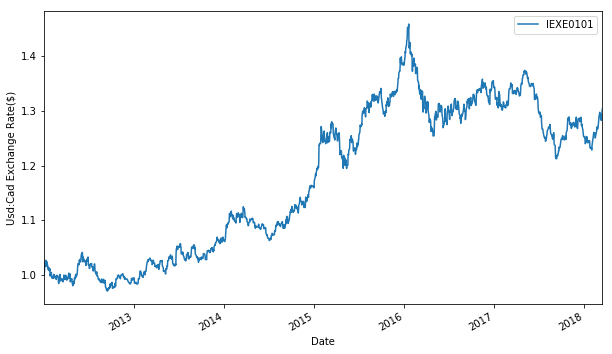

In [36]:

log_returns = np.log(1 + Ex['IEXE0101'].pct_change())
log_returns.tail()

type(log_returns)

Ex.plot(figsize=(10,6))
plt.ylabel("Usd:Cad Exchange Rate($)")
plt.xlabel("Date")
plt.show();


- Plotting the log returns

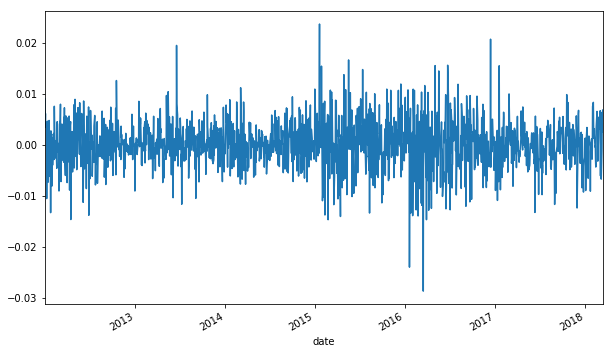

In [37]:
log_returns.plot(figsize=(10,6));

### Finding out the variables required for the calculation of Brownian motion 
- Brownian motion : the formula was first used to model random movement in physics. But has been used to predict the movement of an asset in finance  
- Brownian motion assumes two part of the random movement
  * drift(a constant driving force)
  * random stochastic component(random component) 
- We need 
  * mean 
  * variance (historical volatility) 


In [38]:
u=log_returns.mean()
u
type(u)

float

In [39]:
var=log_returns.var()
var

2.211741495065522e-05

- Brownian motion assumes two parts of movement 
- Drift is the expected rate of return 
- Today's price = Yesterday's price * e ** r
- For standard Monte Carlo : average of historical return - (variance/2) 
- There are other theories are what the drift would be 
 * risk free rate - (variance/2)
 * 0 (supported by random walk theory) 
 



In [40]:
drift=u-(0.5*var)
drift

0.00015393990829146254

In [41]:
stdev = log_returns.std()
stdev

0.004702915579792521

In [42]:
#type(drift)
#type(stdev)

In [43]:
drift=np.array(drift)
#type(drift)

In [ ]:
#stdev=np.array(stdev)
#type(stdev)
#drift.values
#stdev.values
#norm.ppf(0.95)

### Central Limit Theorum 
- if we graph enough periodical daily returns of an asset, the graph should form a normal distribution, bell shaped graph

TP = YS * e ** r
TP = Tomorrow's stock price 
S = Today's stock price 
r = priodical daily rate of return



For the random component, we need to randomize. This can be done by numpy "rand" function. As an example, the following code will create a multidimensional array


In [44]:
x=np.random.rand(10,2)
x
norm.ppf(x)

array([[ 0.44142395, -0.58864481],
       [ 1.08477092, -0.48655281],
       [-0.17016915, -0.09064255],
       [ 0.71081071,  0.04381059],
       [ 0.18524514,  1.6752729 ],
       [ 0.09901985, -0.06993622],
       [ 0.31092312,  0.02128062],
       [-1.11152976,  1.48613965],
       [-0.66496696,  0.5217621 ],
       [-1.83367091,  0.38711609]])

In [45]:
Z=norm.ppf(np.random.rand(10,2))
Z

array([[ 0.54119352,  0.35334973],
       [-1.13193806,  0.48770326],
       [ 0.3570941 , -1.43058987],
       [ 0.82101125, -0.95652066],
       [ 0.79303437,  0.76920485],
       [ 0.31714465, -0.36607236],
       [-0.28967563, -0.34041149],
       [ 0.76375432, -0.05471764],
       [ 0.41497138, -0.90096198],
       [ 1.67897749,  0.27714442]])

The following code set the number of iterations (the number of trials) and t_intervals (the length of projection)  

In [46]:
t_intervals=1000
iterations=500

This is the formula we used to build our model 
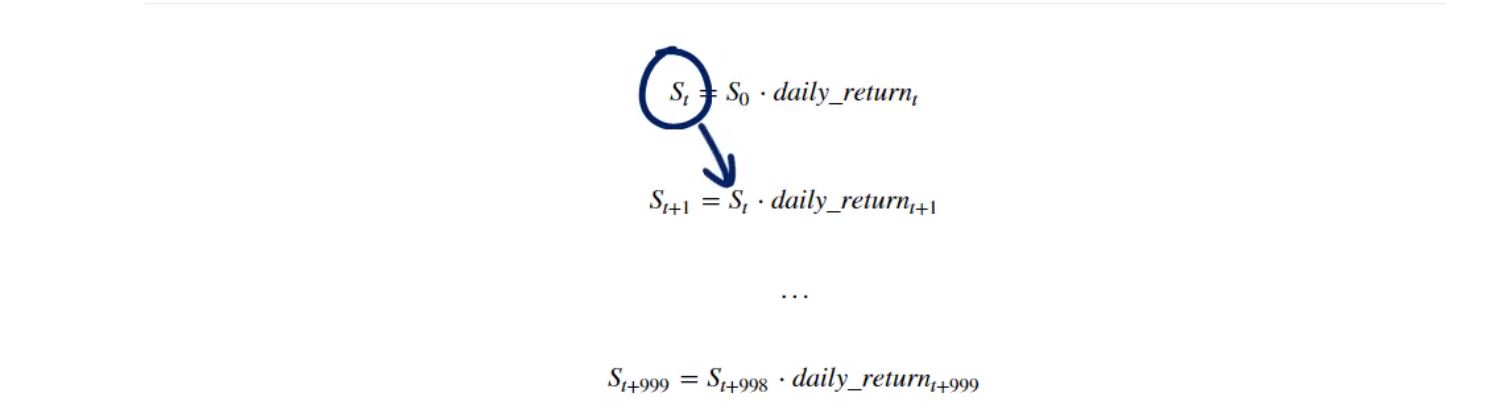

In [47]:
daily_returns = np.exp(drift + stdev * norm.ppf(np.random.rand(t_intervals, iterations)))

In [48]:
type(daily_returns)

numpy.ndarray

In [49]:
S0=Ex.iloc[-1,0]
S0

1.3031999999999999

In [50]:
price_list=np.zeros_like(daily_returns)

In [51]:
price_list

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [52]:
price_list[0]=S0
price_list

array([[ 1.3032,  1.3032,  1.3032, ...,  1.3032,  1.3032,  1.3032],
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       ..., 
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ]])

In [53]:
for t in range(1,t_intervals):
    price_list[t]=price_list[t-1]*daily_returns[t]

In [54]:
price_list


array([[ 1.3032    ,  1.3032    ,  1.3032    , ...,  1.3032    ,
         1.3032    ,  1.3032    ],
       [ 1.30448857,  1.30540432,  1.30273486, ...,  1.30118525,
         1.30534428,  1.29569807],
       [ 1.30580517,  1.31427524,  1.30098031, ...,  1.30536871,
         1.29658826,  1.3026855 ],
       ..., 
       [ 1.91934222,  1.71858308,  1.47852854, ...,  1.50765406,
         1.65107141,  1.81264354],
       [ 1.90971317,  1.71625522,  1.47341326, ...,  1.50752504,
         1.65285489,  1.79981331],
       [ 1.90207397,  1.70447098,  1.48571302, ...,  1.50456637,
         1.65024552,  1.80040295]])

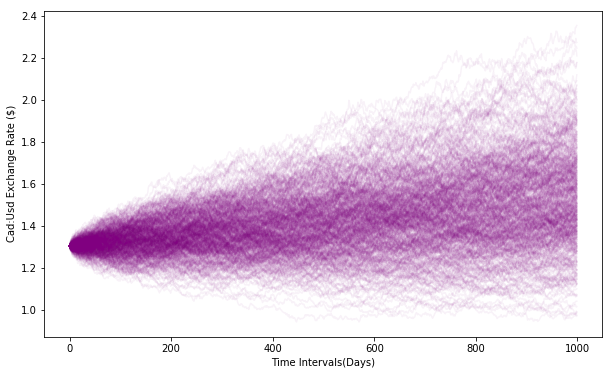

In [56]:
plt.figure(figsize=(10,6));
plt.plot(price_list,color="purple",alpha=0.05);
plt.xlabel("Time Intervals(Days)")
plt.ylabel("Cad:Usd Exchange Rate ($)");

In [58]:
price_list.shape

prediction=pd.DataFrame(price_list)
prediction.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.303200,1.303200,1.303200,1.303200,1.303200,1.303200,1.303200,1.303200,1.303200,1.303200,...,1.303200,1.303200,1.303200,1.303200,1.303200,1.303200,1.303200,1.303200,1.303200,1.303200
1,1.304489,1.305404,1.302735,1.302376,1.304547,1.297438,1.316616,1.297581,1.315484,1.295139,...,1.302607,1.296365,1.306323,1.290382,1.303265,1.297085,1.299970,1.301185,1.305344,1.295698
2,1.305805,1.314275,1.300980,1.304983,1.304194,1.285648,1.315530,1.301066,1.312183,1.296241,...,1.300695,1.298607,1.304419,1.290299,1.299672,1.300134,1.298975,1.305369,1.296588,1.302685
3,1.310507,1.317367,1.292197,1.295084,1.304309,1.286041,1.323630,1.298826,1.309575,1.303246,...,1.310008,1.297701,1.311052,1.290289,1.299928,1.302005,1.299010,1.301740,1.289006,1.304194
4,1.321808,1.323877,1.284760,1.292438,1.302949,1.290753,1.321118,1.294390,1.306289,1.306045,...,1.306540,1.309912,1.309922,1.290992,1.301624,1.310010,1.305910,1.301795,1.291672,1.310954


In [59]:
pred=prediction.iloc[365,:]



1.3856823057476846

In [60]:

plt.hist(pred,bins=25)
plt.ylabel("Frequency")
plt.xlabel("Usd:Cad Exchange Rate ($)");
plt.show()

count    500.000000
mean       1.385682
std        0.128135
min        1.012004
25%        1.296627
50%        1.376892
75%        1.471281
max        1.756626
Name: 365, dtype: float64

In [61]:
pred=prediction.iloc[365,:]
pred.mean()

1.3856823057476846

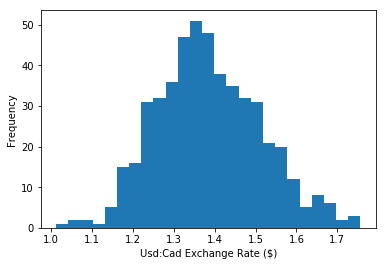

In [62]:
pred=prediction.iloc[90,:]
mean90=pred.mean()

pred1=prediction.iloc[90,:]>1.4
prob=pred1.sum()/500 *100

plt.hist(pred,bins=25)
plt.ylabel("Frequency")
plt.xlabel("Usd:Cad Exchange Rate ($)");
plt.show()



print("The mean for 90th day distribution is %f" %(mean90))
print( "Probability of exchange rate over 1.4 after 90 days: %d percent" %(prob))